In [15]:
import json
import pandas as pd
import os
from collections import defaultdict
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter


In [2]:

# Your class name mapping
class_names = {
    0:"Speed Limit (20Km/hr)", 1:"Speed Limit (30Km/hr)", 
    2:"Speed Limit (50Km/hr)", 3: "Speed Limit (60Km/hr)", 
    4: "Speed Limit (70Km/hr)", 5: "Speed Limit (80Km/hr)",
    6: "End of Speed Limit (80Km/hr)", 7: "Speed Limit (100Km/hr)", 
    8: "Speed Limit (120Km/hr)", 9: "No Passing", 
    10: "No Passing for trucks over 3.5 tons", 11: "Right of way", 
    12: "Priotity Road", 13: "Yeild right of way",
    14: "Stop", 15: "Prohibited for all vehicles",
    16: "Trucks and tractors over 3.5 tons prohibited", 17: "Entery prohibited",
    18: "Danger", 19: "Single curve left",
    20: "Single curve right", 21: "Double curve",
    22: "Rough road", 23: "Slippery road",
    24: "Road narrows", 25: "Construction side ahead",
    26: "Signal lights ahead", 27: "Pedestrian crosswalk ahead",
    28: "Children", 29: "Bicycle crossing",
    30: "Unexpected ice danger", 31: "Wild animal crossing",
    32: "End of restrection", 33: "Mandatory direction of travel right",
    34: "Mandatory direction of travel left", 35: "Mandatory direction of travel ahead",
    36: "Straight or right", 37: "Straight or left",
    38: "Keep right", 39: "Keep left",
    40: "Traffic circle", 41: "End of no passing zone cars",
    42: "End of no passing zone vehicle over 3.5 tons"
}


In [ ]:


# Normalize text
def normalize(text):
    return text.lower().strip()

# Normalize all GT class names for exact matching
normalized_class_names = {cid: normalize(name) for cid, name in class_names.items()}

# Exact match only
def match_prediction_to_class(predicted_name):
    predicted_norm = normalize(predicted_name)
    for cid, gt_norm in normalized_class_names.items():
        if predicted_norm == gt_norm:
            return cid
    return None

# Load GT CSV
gt = pd.read_csv("../1_Datasets/GTSRB/Test.csv")

# Counting stats
correct_count = defaultdict(int)
misclassified_count = defaultdict(int)
predictions_per_class = defaultdict(list)

# To build confusion matrix later
detailed_rows = []

# Folder containing predictions
prediction_dir = "../1_Datasets/llama4scout"

# Process test samples
for idx, row in gt.iterrows():
    true_class = int(row["ClassId"])
    true_name = class_names[true_class]
    img_path = row["Path"]

    json_file = os.path.join(prediction_dir, os.path.basename(img_path).replace(".png", ".json"))
    if not os.path.exists(json_file):
        continue

    with open(json_file, "r") as f:
        pred = json.load(f)

    predicted_name = pred["traffic_sign_name"]
    predicted_class = match_prediction_to_class(predicted_name)

    # Store prediction text for this true class
    predictions_per_class[true_class].append(predicted_name)

    # Save per-image result
    detailed_rows.append({
        "Image": img_path,
        "TrueClassId": true_class,
        "TrueClassName": true_name,
        "PredictedName": predicted_name,
        "MappedPredictedClass": predicted_class
    })

    # Exact match logic
    if predicted_class == true_class:
        correct_count[true_class] += 1
    else:
        misclassified_count[true_class] += 1

# Save per-image predictions
df_detailed = pd.DataFrame(detailed_rows)
df_detailed.to_csv("./Results/csv/detailed_predictions_exact.csv", index=False)

# Compile results per class
results = []
for cid in class_names.keys():

    support = sum(
        os.path.exists(os.path.join(prediction_dir, os.path.basename(p).replace(".png", ".json")))
        for p in gt.loc[gt["ClassId"] == cid, "Path"]
    )

    correct = correct_count[cid]
    mis = misclassified_count[cid]
    mis_rate = mis / support if support > 0 else 0

    # Most common predicted label for this class
    if len(predictions_per_class[cid]) > 0:
        most_common_pred = Counter(predictions_per_class[cid]).most_common(1)[0][0]
    else:
        most_common_pred = None

    results.append([
        cid,
        class_names[cid],           # ground truth sign name
        support,
        correct,
        mis,
        round(mis_rate, 4),
        most_common_pred            # model's top prediction for this class
    ])

df_results = pd.DataFrame(results, columns=[
    "ClassId", "SignName", "Support", "Correct", "Misclassified", "MisRate", "MostFrequentPrediction"
])

df_sorted = df_results.sort_values("MisRate", ascending=False)
print(df_sorted.head())


   ClassId               SignName  Support  Correct  Misclassified  MisRate  \
0        0  Speed Limit (20Km/hr)       10        0             10      1.0   
1        1  Speed Limit (30Km/hr)       63        0             63      1.0   
2        2  Speed Limit (50Km/hr)       52        0             52      1.0   
3        3  Speed Limit (60Km/hr)       41        0             41      1.0   
4        4  Speed Limit (70Km/hr)       55        0             55      1.0   

  MostFrequentPrediction  
0            Speed Limit  
1         Speed Limit 30  
2         Speed Limit 50  
3                   Stop  
4            Speed Limit  


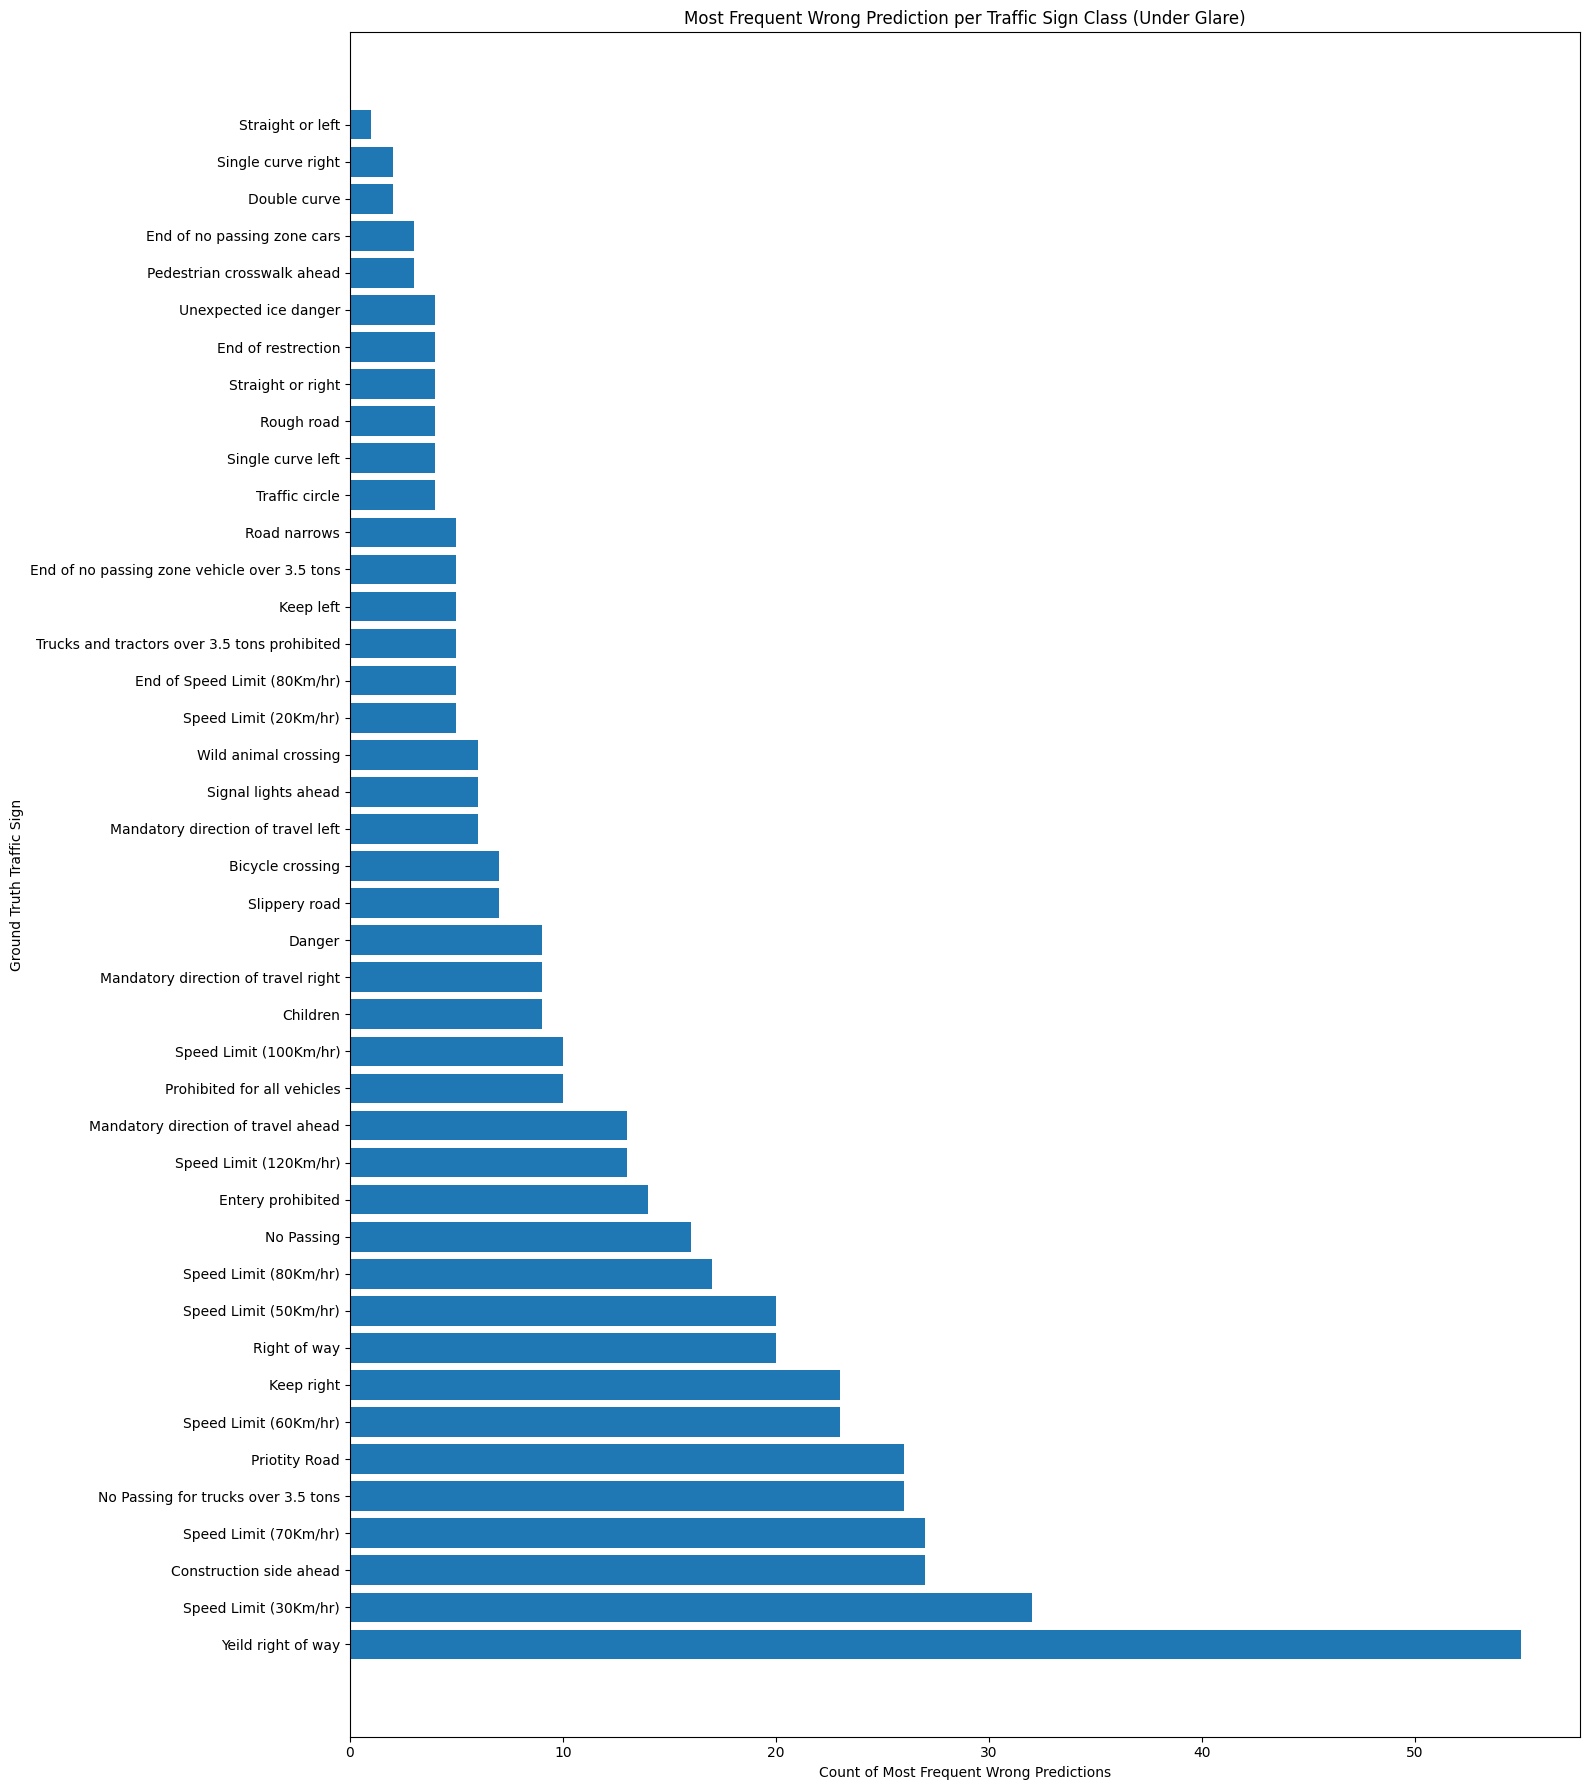

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load per-image predictions
df = pd.read_csv("detailed_predictions_exact.csv")

# 1. Filter misclassified rows only
df_mis = df[df["MappedPredictedClass"] != df["TrueClassId"]]

# 2. For each class, compute the most frequent wrong predicted text
most_freq_wrong = {}

for class_id, group in df_mis.groupby("TrueClassId"):
    preds = group["PredictedName"].astype(str).tolist()
    
    if len(preds) > 0:
        most_common = Counter(preds).most_common(1)[0]
        most_freq_wrong[class_id] = {
            "TrueClassName": group["TrueClassName"].iloc[0],
            "MostFrequentWrongPrediction": most_common[0],
            "Count": most_common[1]
        }
    else:
        most_freq_wrong[class_id] = {
            "TrueClassName": group["TrueClassName"].iloc[0],
            "MostFrequentWrongPrediction": "None",
            "Count": 0
        }

# Convert to DataFrame for plotting
plot_df = pd.DataFrame.from_dict(most_freq_wrong, orient="index")

# Sort by Count descending
plot_df = plot_df.sort_values("Count", ascending=False)

# 3. Plot horizontal bar chart
plt.figure(figsize=(16, 18))

plt.barh(
    plot_df["TrueClassName"],
    plot_df["Count"]
)

plt.xlabel("Count of Most Frequent Wrong Predictions")
plt.ylabel("Ground Truth Traffic Sign")
plt.title("Most Frequent Wrong Prediction per Traffic Sign Class (Under Glare)")

plt.tight_layout()
plt.savefig("most_frequent_wrong_predictions_per_class.png", dpi=200)
plt.show()

# Optional: also save table
plot_df.to_csv("most_frequent_wrong_prediction_table.csv", index=False)


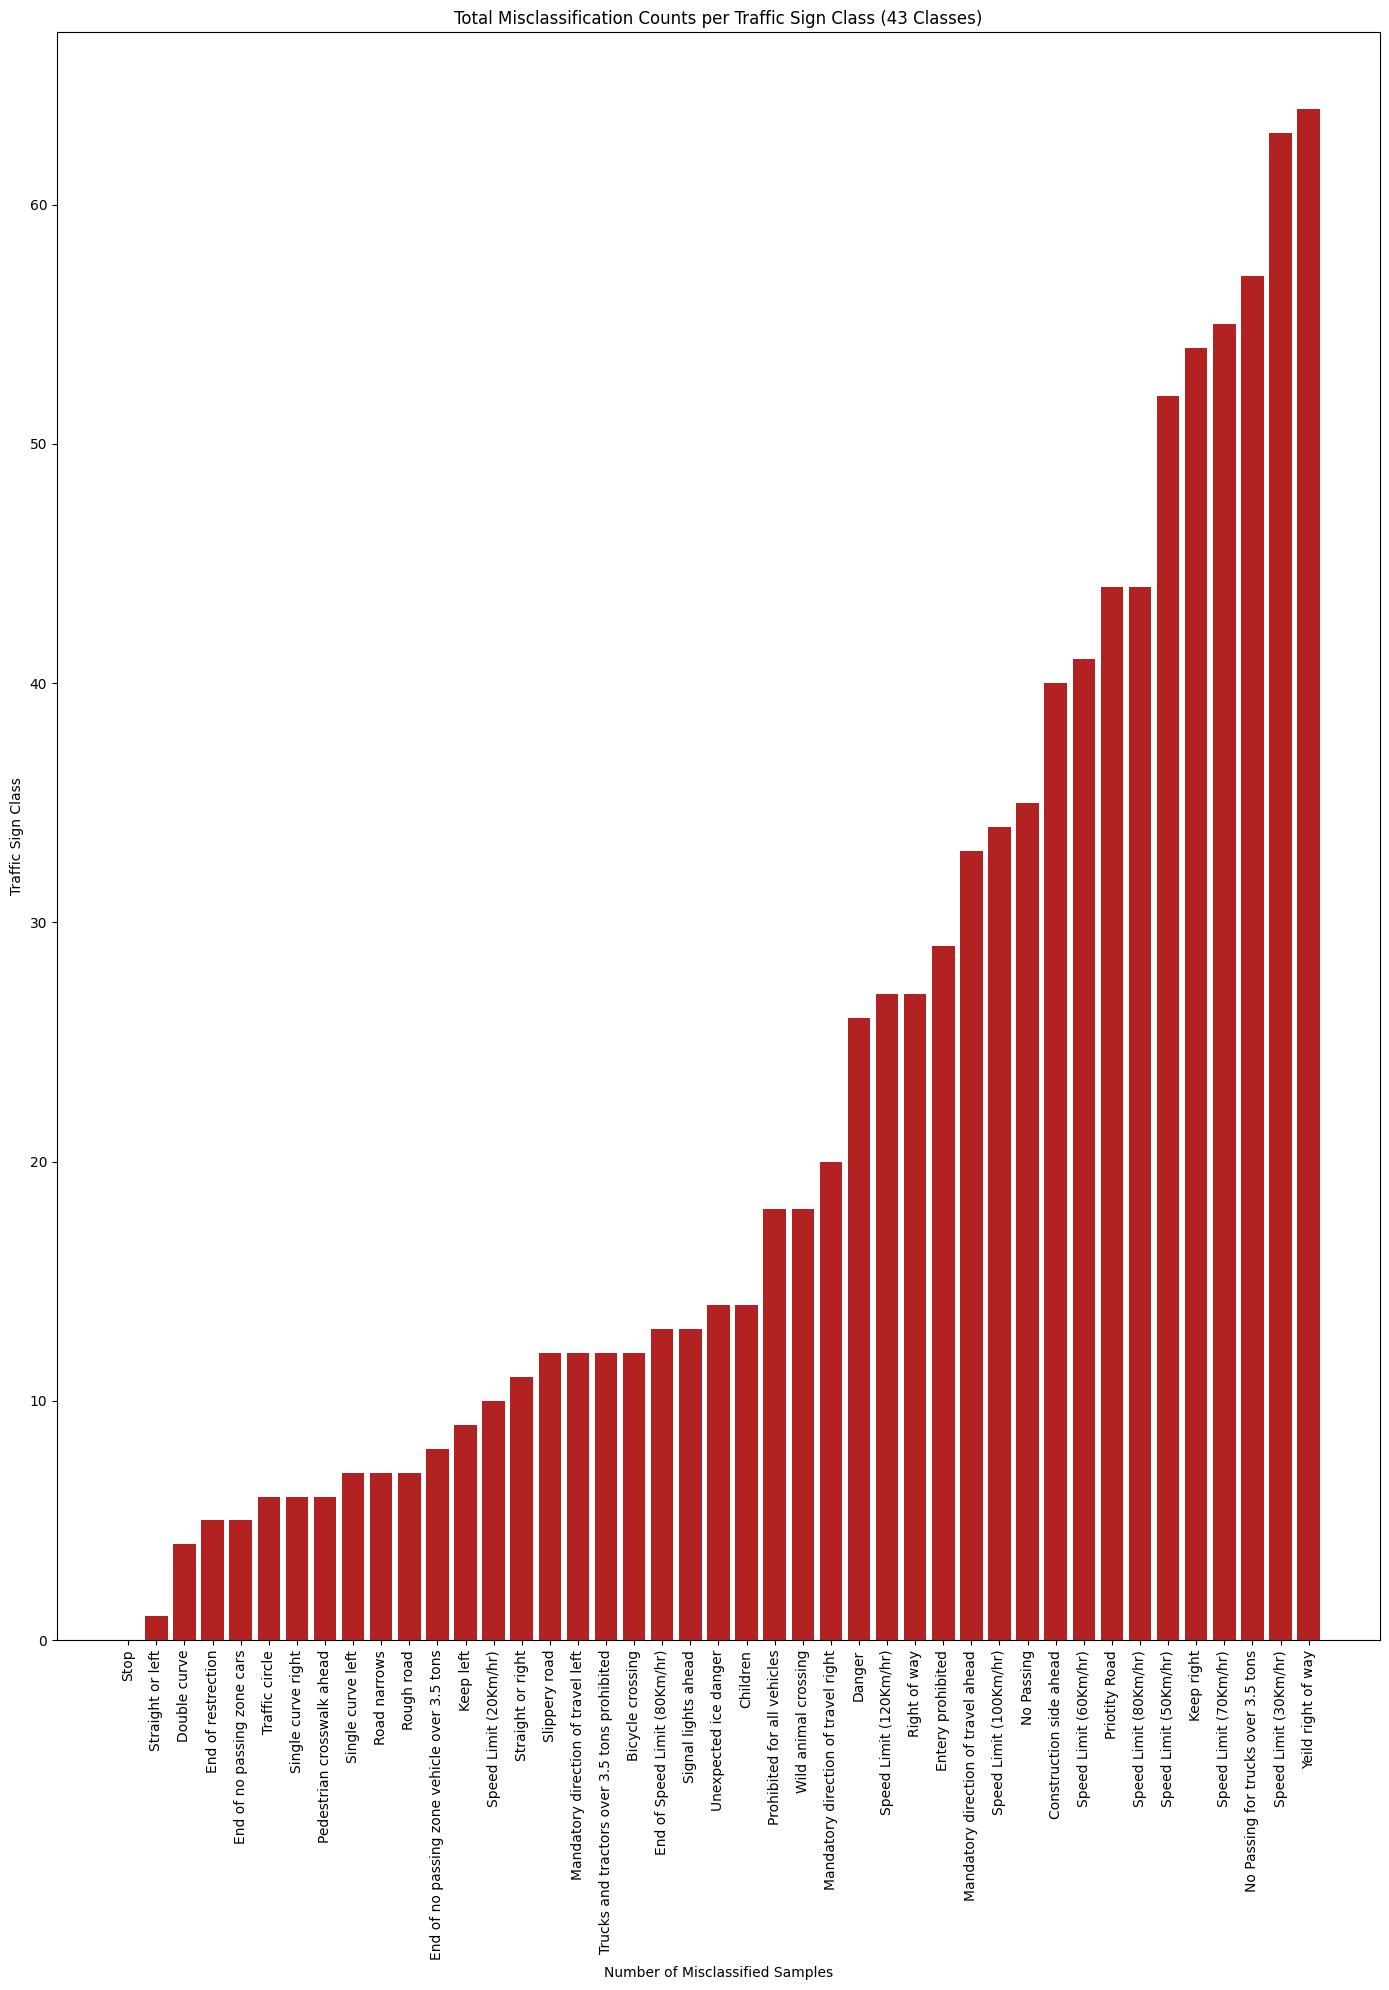

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load per-image prediction results
df = pd.read_csv("detailed_predictions_exact.csv")

# Create a misclassification flag
df["IsMisclassified"] = df["MappedPredictedClass"] != df["TrueClassId"]

# Count misclassifications per class
mis_count = df.groupby(["TrueClassId", "TrueClassName"])["IsMisclassified"].sum().reset_index()

# Rename for clarity
mis_count.rename(columns={"IsMisclassified": "TotalMisclassified"}, inplace=True)

# Sort worst to best
mis_count = mis_count.sort_values("TotalMisclassified", ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(14, 20))

plt.bar(
    mis_count["TrueClassName"],
    mis_count["TotalMisclassified"],
    color="firebrick"
)
plt.xticks(rotation=90)

plt.xlabel("Number of Misclassified Samples")
plt.ylabel("Traffic Sign Class")
plt.title("Total Misclassification Counts per Traffic Sign Class (43 Classes)")

plt.tight_layout()
plt.savefig("total_misclassification_counts_per_class.png", dpi=200)
plt.show()

# Save table
# mis_count.to_csv("total_misclassification_counts_per_class.csv", index=False)
